<font size=6><b>**Тестовое от Работа.ру**</b></font>
    
<font size=6><b>**Бинарная классификации откликов**</b></font>

<font size=4><b>Часть 2. Feature engineering.</b></font>

***

# Постановка задачи

**Заказчик**  
Работа.ру

**Цель**  
Автоматизировать труд рекрутеров в части просмотра и оценки резюме, что позволит существенно сэкономить ресурсы по подбору персонала.

**Задачи**  

1. Проанализировать датасет и провести обработку данных.
1. *Сгенерировать новые признаки.*
1. На основе результатов предыдущего шага определить модель для предсказания  факта приглашения работодателем откликнувшегося соискателя на собеседование.

**Исходные данные**  

Данные представлены в виде датасета с основными параметрами вакансий\резюме (название, описание, требования по опыту работы, графику работы, знанию иностранных языков, перечень навыков и т. д.). 
Вакансии и резюме представлены парами.  
Целевая переменная первой задачи – откликнется (1) или не откликнется (0) соискатель с данным резюме на данную вакансию.  
Целевая переменная второй задачи – пригласит (1) или не пригласит (0) работодатель откликнувшегося соискателя на собеседование.


# Подготовка окружения

Загрузим библиотеки, необходимые для выполнения проекта.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
try:
    import phik
except Exception:
    ! pip install phik
    import phik

In [3]:
try:
    import fasttext
    import fasttext.util
except Exception:
    !pip install fasttext
    import fasttext
    import fasttext.util

In [4]:
# автоформатирование Jupyter lab
try:
    %load_ext lab_black
except:
    None

In [5]:
# отображение таблиц без ограничения на количество столбцов
pd.set_option("display.max_columns", None)

Загрузим сами данные.

In [6]:
try:
    df = pd.read_csv("/content/vacancy_resume_data_eda.csv")  # Colab
except FileNotFoundError:
    df = pd.read_csv("vacancy_resume_data_eda.csv")  # Local

In [7]:
df.head()

,resume_id,vacancy_id,birth_date,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear_stem,vacancy_custom_position_clear_stem,vacancy_description_clear_stem
0,28826595,43881267,1996.0,20000.0,1,False,False,4,False,False,81.0,0.0,3,1,30000,40000.0,4,-1.0,927123,False,1,0,0,1,корректор,менеджер переводчик,требован высш лингвистическ филологическ педаг...
1,25778536,43454765,1970.0,-1.0,1,False,True,4,False,True,87.0,5.0,3,1,40000,-1.0,0,0.0,1141124,False,1,-1,0,1,шеф повар,шеф повар,торгов сет перекресток переход лучш наш сет ма...
2,28782671,43833295,1984.0,35000.0,1,False,True,4,False,True,88.0,-1.0,156,6,-1,-1.0,0,1.0,1765004,False,57,-1,0,1,дизайнер,дизайнер интерьер,обязан нужн передела офис м жил апартамент сда...
3,23624154,42093862,2003.0,45000.0,57,False,False,4,False,True,85.0,-1.0,209,1,-1,-1.0,0,-1.0,1739407,False,1,-1,0,1,помощник юрист младш юрист,администратор выходн дня,обязан связ пациент при звонк зап при подтверж...
4,26474618,43740592,1998.0,21000.0,2,False,False,-1,False,False,77.0,-1.0,4,2,28000,35000.0,0,-1.0,714925,False,2,-1,0,1,грузчик,грузчик магазин детск товар ночн смен,друз открыт ваканс разнорабоч грузчик смен обя...


# Добавление признаков

## Равенство категорий

В рассматриваемом датасете содержатся признаки с id городов, образования как в резюме, так и в вакансиях. 
Представляется целесообразным включение дополнительного признака, который принимает значение `1` в случае, если указанные признаки совпадают и `0` - в противном случае.

Аналогичным образом добавим признаки сравнения зарплатных ожиданий в резюме и зарплатной вилки в вакансии, а также вхождения очищенного и лемматизированного названия должности резюме в название должности вакансии и ее описания.

In [8]:
def feature_equalator(feature_pair, new_feature_name):
    df[new_feature_name] = df.apply(
        lambda x: (df[feature_pair[0]] == df[feature_pair[1]]) * 1, axis=1
    )


def feature_comparator(feature_pair, new_feature_name):
    df[new_feature_name] = df.apply(
        lambda x: (df[feature_pair[0]] > df[feature_pair[1]]) * 1, axis=1
    )


def feature_inner(row, feature_pair):
    return (row[feature_pair[0]] in row[feature_pair[1]]) * 1

In [9]:
feature_id_pairs = [
    ["resume_city_id", "vacancy_city_id"],
    ["resume_offer_education_id", "vacancy_offer_education_id"],
]

feature_compairable_pairs = [
    ["resume_salary_from", "vacancy_salary_from"],
    ["resume_salary_from", "vacancy_salary_to"],
    ["resume_offer_experience_year_count", "vacancy_offer_experience_year_count"],
]

feature_text_pairs = [
    ["resume_position_clear_stem", "vacancy_custom_position_clear_stem"],
    ["vacancy_custom_position_clear_stem", "resume_position_clear_stem"],
    ["resume_position_clear_stem", "vacancy_description_clear_stem"],
]

In [10]:
new_features = []

for i in feature_id_pairs:
    new_features.append(i[0] + "_=_" + i[1])
    df[new_features[-1]] = (df[i[0]] == df[i[1]]) * 1

for i in feature_compairable_pairs:
    new_features.append(i[0] + "_=_" + i[1])
    df[new_features[-1]] = (df[i[0]] == df[i[1]]) * 1
    new_features.append(i[0] + "_>_" + i[1])
    df[new_features[-1]] = (df[i[0]] > df[i[1]]) * 1

for i in feature_text_pairs:
    new_features.append(i[0] + "_in_" + i[1])
    df[new_features[-1]] = df.apply(feature_inner, args=[i], axis=1)

In [11]:
df.head()

,resume_id,vacancy_id,birth_date,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear_stem,vacancy_custom_position_clear_stem,vacancy_description_clear_stem,resume_city_id_=_vacancy_city_id,resume_offer_education_id_=_vacancy_offer_education_id,resume_salary_from_=_vacancy_salary_from,resume_salary_from_>_vacancy_salary_from,resume_salary_from_=_vacancy_salary_to,resume_salary_from_>_vacancy_salary_to,resume_offer_experience_year_count_=_vacancy_offer_experience_year_count,resume_offer_experience_year_count_>_vacancy_offer_experience_year_count,resume_position_clear_stem_in_vacancy_custom_position_clear_stem,vacancy_custom_position_clear_stem_in_resume_position_clear_stem,resume_position_clear_stem_in_vacancy_description_clear_stem
0,28826595,43881267,1996.0,20000.0,1,False,False,4,False,False,81.0,0.0,3,1,30000,40000.0,4,-1.0,927123,False,1,0,0,1,корректор,менеджер переводчик,требован высш лингвистическ филологическ педаг...,1,1,0,0,0,0,0,1,0,0,0
1,25778536,43454765,1970.0,-1.0,1,False,True,4,False,True,87.0,5.0,3,1,40000,-1.0,0,0.0,1141124,False,1,-1,0,1,шеф повар,шеф повар,торгов сет перекресток переход лучш наш сет ма...,1,0,0,0,1,0,0,1,1,1,0
2,28782671,43833295,1984.0,35000.0,1,False,True,4,False,True,88.0,-1.0,156,6,-1,-1.0,0,1.0,1765004,False,57,-1,0,1,дизайнер,дизайнер интерьер,обязан нужн передела офис м жил апартамент сда...,0,0,0,1,0,1,0,0,1,0,0
3,23624154,42093862,2003.0,45000.0,57,False,False,4,False,True,85.0,-1.0,209,1,-1,-1.0,0,-1.0,1739407,False,1,-1,0,1,помощник юрист младш юрист,администратор выходн дня,обязан связ пациент при звонк зап при подтверж...,0,0,0,1,0,1,1,0,0,0,0
4,26474618,43740592,1998.0,21000.0,2,False,False,-1,False,False,77.0,-1.0,4,2,28000,35000.0,0,-1.0,714925,False,2,-1,0,1,грузчик,грузчик магазин детск товар ночн смен,друз открыт ваканс разнорабоч грузчик смен обя...,1,0,0,0,0,0,1,0,1,0,1


## Embeddings

Простое вхождение названия должности резюме в название должности вакансии и ее описания не показывает их смысловую окраску, для рассмотрения которой необходимо добавление эмбедингов текста.
С этой целью воспользуемся библиотекой `fasttext` и обучим модель на модель на полном корпусе слов.
Указанная модель, как правило, обеспечивает качественные решения в условиях ограниченных вычислительных ресурсов.

In [12]:
try:
    model = fasttext.load_model("fast_text.bin")

except ValueError:
    corpus = (
        df["resume_position_clear_stem"]
        + " "
        + df["vacancy_custom_position_clear_stem"]
        + " "
        + df["vacancy_description_clear_stem"]
        + " /n "
    )
    corpus.to_csv("corpus.csv", index=False)
    model = fasttext.train_unsupervised("corpus.csv")
    model.save_model("fast_text.bin")

In [13]:
def embedder(row, feature):
    return model.get_sentence_vector(row[f"{feature}_clear_stem"])

In [14]:
df["resume_position_emb"] = df.apply(embedder, args=["resume_position"], axis=1)
df["vacancy_custom_position_emb"] = df.apply(
    embedder, args=["vacancy_custom_position"], axis=1
)
df["vacancy_description_emb"] = df.apply(embedder, args=["vacancy_description"], axis=1)

In [15]:
df.head()

,resume_id,vacancy_id,birth_date,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear_stem,vacancy_custom_position_clear_stem,vacancy_description_clear_stem,resume_city_id_=_vacancy_city_id,resume_offer_education_id_=_vacancy_offer_education_id,resume_salary_from_=_vacancy_salary_from,resume_salary_from_>_vacancy_salary_from,resume_salary_from_=_vacancy_salary_to,resume_salary_from_>_vacancy_salary_to,resume_offer_experience_year_count_=_vacancy_offer_experience_year_count,resume_offer_experience_year_count_>_vacancy_offer_experience_year_count,resume_position_clear_stem_in_vacancy_custom_position_clear_stem,vacancy_custom_position_clear_stem_in_resume_position_clear_stem,resume_position_clear_stem_in_vacancy_description_clear_stem,resume_position_emb,vacancy_custom_position_emb,vacancy_description_emb
0,28826595,43881267,1996.0,20000.0,1,False,False,4,False,False,81.0,0.0,3,1,30000,40000.0,4,-1.0,927123,False,1,0,0,1,корректор,менеджер переводчик,требован высш лингвистическ филологическ педаг...,1,1,0,0,0,0,0,1,0,0,0,"[-0.024972122, 0.075425826, -0.1564965, -0.056...","[-0.14046969, 0.011484576, -0.06269358, -0.005...","[-0.027254581, 0.010300931, -0.04782191, -0.06..."
1,25778536,43454765,1970.0,-1.0,1,False,True,4,False,True,87.0,5.0,3,1,40000,-1.0,0,0.0,1141124,False,1,-1,0,1,шеф повар,шеф повар,торгов сет перекресток переход лучш наш сет ма...,1,0,0,0,1,0,0,1,1,1,0,"[-0.10569151, -0.02104893, -0.04535014, -0.132...","[-0.10569151, -0.02104893, -0.04535014, -0.132...","[-0.007883687, 0.01704744, -0.015436896, -0.03..."
2,28782671,43833295,1984.0,35000.0,1,False,True,4,False,True,88.0,-1.0,156,6,-1,-1.0,0,1.0,1765004,False,57,-1,0,1,дизайнер,дизайнер интерьер,обязан нужн передела офис м жил апартамент сда...,0,0,0,1,0,1,0,0,1,0,0,"[-0.03664486, 0.11036156, -0.06441893, -0.0860...","[-0.04568662, 0.070107505, 0.019193608, -0.124...","[0.0028499793, 0.026935484, -0.04455627, -0.09..."
3,23624154,42093862,2003.0,45000.0,57,False,False,4,False,True,85.0,-1.0,209,1,-1,-1.0,0,-1.0,1739407,False,1,-1,0,1,помощник юрист младш юрист,администратор выходн дня,обязан связ пациент при звонк зап при подтверж...,0,0,0,1,0,1,1,0,0,0,0,"[0.0040362235, 0.04351751, -0.08918768, -0.011...","[0.0056288196, 0.03409665, 0.089878194, -0.007...","[-0.01029969, -0.0048395186, -0.029595008, -0...."
4,26474618,43740592,1998.0,21000.0,2,False,False,-1,False,False,77.0,-1.0,4,2,28000,35000.0,0,-1.0,714925,False,2,-1,0,1,грузчик,грузчик магазин детск товар ночн смен,друз открыт ваканс разнорабоч грузчик смен обя...,1,0,0,0,0,0,1,0,1,0,1,"[-0.11716162, 0.08596569, -0.106729515, 0.0240...","[-0.11070168, -0.012781581, 0.020220652, 0.003...","[-0.014853429, 0.01524701, 0.0040501677, -0.05..."


Эмбединги посчитаны.
Однако в связи с ограниченными вычислительными возможностями, передать их целиком в модель машинного обучения не представляется возможным. 
В этой связи проведем расчет расстояния между эмбедингами вручную.

In [16]:
def distance_calculator(row, feature1, feature2):
    return sum((row[feature1] - row[feature2]) ** 2) ** 0.5

In [17]:
df["dist_resume_position_vacancy_custom_position"] = df.apply(
    distance_calculator,
    args=("resume_position_emb", "vacancy_custom_position_emb"),
    axis=1,
)

df["dist_resume_position_vacancy_description"] = df.apply(
    distance_calculator,
    args=["resume_position_emb", "vacancy_description_emb"],
    axis=1,
)

In [18]:
dist_features = [
    "dist_resume_position_vacancy_custom_position",
    "dist_resume_position_vacancy_description",
]

Для уменьшения объема используемой оперативной памяти сохраним эмбединги в отдельный файл и удалим их из датасета.

In [19]:
%%time
df[[
    "resume_position_emb", 
    "vacancy_custom_position_emb", 
    "vacancy_description_emb"
]].to_csv("vacancy_resume_data_emb.csv", index=False)

Wall time: 22min 6s


In [20]:
df = df.drop(
    ["resume_position_emb", "vacancy_custom_position_emb", "vacancy_description_emb"],
    axis=1,
)

## Длина текстов

Добавим признак с длиной текстов.

In [21]:
def row_len(row, feature):
    return len([x for x in row[feature].split(" ")])


def corpus_len(feature):
    df[f"{feature}_len"] = df.apply(row_len, axis=1, args=[f"{feature}_clear_stem"])

In [22]:
corpus_len("resume_position")
corpus_len("vacancy_custom_position")
corpus_len("vacancy_description")

In [23]:
df.head()

,resume_id,vacancy_id,birth_date,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,resume_is_upload_photo,percentage_of_resume_completion,resume_offer_experience_year_count,resume_region_id,vacancy_operating_schedule_id,vacancy_salary_from,vacancy_salary_to,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_offer_experience_year_id,target_task_1,target_task_2,resume_position_clear_stem,vacancy_custom_position_clear_stem,vacancy_description_clear_stem,resume_city_id_=_vacancy_city_id,resume_offer_education_id_=_vacancy_offer_education_id,resume_salary_from_=_vacancy_salary_from,resume_salary_from_>_vacancy_salary_from,resume_salary_from_=_vacancy_salary_to,resume_salary_from_>_vacancy_salary_to,resume_offer_experience_year_count_=_vacancy_offer_experience_year_count,resume_offer_experience_year_count_>_vacancy_offer_experience_year_count,resume_position_clear_stem_in_vacancy_custom_position_clear_stem,vacancy_custom_position_clear_stem_in_resume_position_clear_stem,resume_position_clear_stem_in_vacancy_description_clear_stem,dist_resume_position_vacancy_custom_position,dist_resume_position_vacancy_description,resume_position_len,vacancy_custom_position_len,vacancy_description_len
0,28826595,43881267,1996.0,20000.0,1,False,False,4,False,False,81.0,0.0,3,1,30000,40000.0,4,-1.0,927123,False,1,0,0,1,корректор,менеджер переводчик,требован высш лингвистическ филологическ педаг...,1,1,0,0,0,0,0,1,0,0,0,0.859948,0.838203,1,2,89
1,25778536,43454765,1970.0,-1.0,1,False,True,4,False,True,87.0,5.0,3,1,40000,-1.0,0,0.0,1141124,False,1,-1,0,1,шеф повар,шеф повар,торгов сет перекресток переход лучш наш сет ма...,1,0,0,0,1,0,0,1,1,1,0,0.000000,0.784030,2,2,175
2,28782671,43833295,1984.0,35000.0,1,False,True,4,False,True,88.0,-1.0,156,6,-1,-1.0,0,1.0,1765004,False,57,-1,0,1,дизайнер,дизайнер интерьер,обязан нужн передела офис м жил апартамент сда...,0,0,0,1,0,1,0,0,1,0,0,0.460166,0.813258,1,2,37
3,23624154,42093862,2003.0,45000.0,57,False,False,4,False,True,85.0,-1.0,209,1,-1,-1.0,0,-1.0,1739407,False,1,-1,0,1,помощник юрист младш юрист,администратор выходн дня,обязан связ пациент при звонк зап при подтверж...,0,0,0,1,0,1,1,0,0,0,0,0.837509,0.717521,4,3,61
4,26474618,43740592,1998.0,21000.0,2,False,False,-1,False,False,77.0,-1.0,4,2,28000,35000.0,0,-1.0,714925,False,2,-1,0,1,грузчик,грузчик магазин детск товар ночн смен,друз открыт ваканс разнорабоч грузчик смен обя...,1,0,0,0,0,0,1,0,1,0,1,0.661000,0.772663,1,6,69


In [24]:
len_features = [
    "resume_position_len",
    "vacancy_custom_position_len",
    "vacancy_description_len",
]

## Логарифмирование

Добавим признаки, значение которых равно натуральному логорифму от признаков со значениями зарплаты.
Получившиеся пропуски от нулевых значений заменим средним по столбцу.

In [25]:
log_features = [
    "resume_salary_from",
    "vacancy_salary_from",
    "vacancy_salary_to",
]

In [26]:
new_log_features = []

for i in log_features:
    df[i + "_log"] = np.log(df[i])
    df[i + "_log"] = df[i + "_log"].fillna(df[i + "_log"].mean())
    new_log_features.append(i + "_log")

C:\ProgramData\Anaconda3\envs\praktikum_env_win_new\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Свертка

Последними из созданных признаков введем "свертки", которые формируются путем суммирования значений бинарных признаков. 
При этом последние разобьем на две группы - доступные в "оригинальном" датасете и созданные в процессе фич инжиниринга.

In [27]:
conv_res_features = [
    "resume_city_search_job",
    "resume_is_leaving",
    "resume_is_foreign_language",
    "resume_is_upload_photo",
    "vacancy_is_agency",
]

conv_new_fetures = [
    "resume_city_id_=_vacancy_city_id",
    "resume_offer_education_id_=_vacancy_offer_education_id",
    "resume_salary_from_=_vacancy_salary_from",
    "resume_salary_from_>_vacancy_salary_from",
    "resume_salary_from_=_vacancy_salary_to",
    "resume_salary_from_>_vacancy_salary_to",
    "resume_offer_experience_year_count_=_vacancy_offer_experience_year_count",
    "resume_offer_experience_year_count_>_vacancy_offer_experience_year_count",
    "resume_position_clear_stem_in_vacancy_custom_position_clear_stem",
    "vacancy_custom_position_clear_stem_in_resume_position_clear_stem",
    "resume_position_clear_stem_in_vacancy_description_clear_stem",
]

df["conv_res_features"] = df[conv_res_features].sum(axis=1)
df["conv_new_fetures"] = df[conv_new_fetures].sum(axis=1)

conv_features = ["conv_res_features", "conv_new_fetures"]

# Анализ созданных признаков

## Категориальные признаки

Построим гистограммы распределения созданных категориальных признаков.

In [28]:
y_s = ["target_task_1", "target_task_2"]

df_task_2 = df[df[y_s[0]] == 1]

In [29]:
def plotter_2cols(
    features,
    figsize=(12, 17),
    bins="auto",
    kde=False,
    binwidth=None,
    log_scale=(False, False),
    xlim=None,
    ylim=None,
    binrange=None,
):
    _, axs = plt.subplots(len(features), 2, figsize=figsize)

    df_task_2 = df[df["target_task_1"] == 1]
    df_s = [df, df_task_2]
    ax = None

    for i in range(len(features)):
        for j in range(2):
            try:
                ax = axs[i, j]
            except IndexError:
                ax = axs[j]

            sns.histplot(
                data=df_s[j],
                x=features[i],
                bins=bins,
                binwidth=binwidth,
                binrange=binrange,
                hue=y_s[j],
                multiple="dodge",
                ax=ax,
                kde=kde,
                log_scale=log_scale,
            )
            ax.grid(True)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.grid(True)

    plt.show()

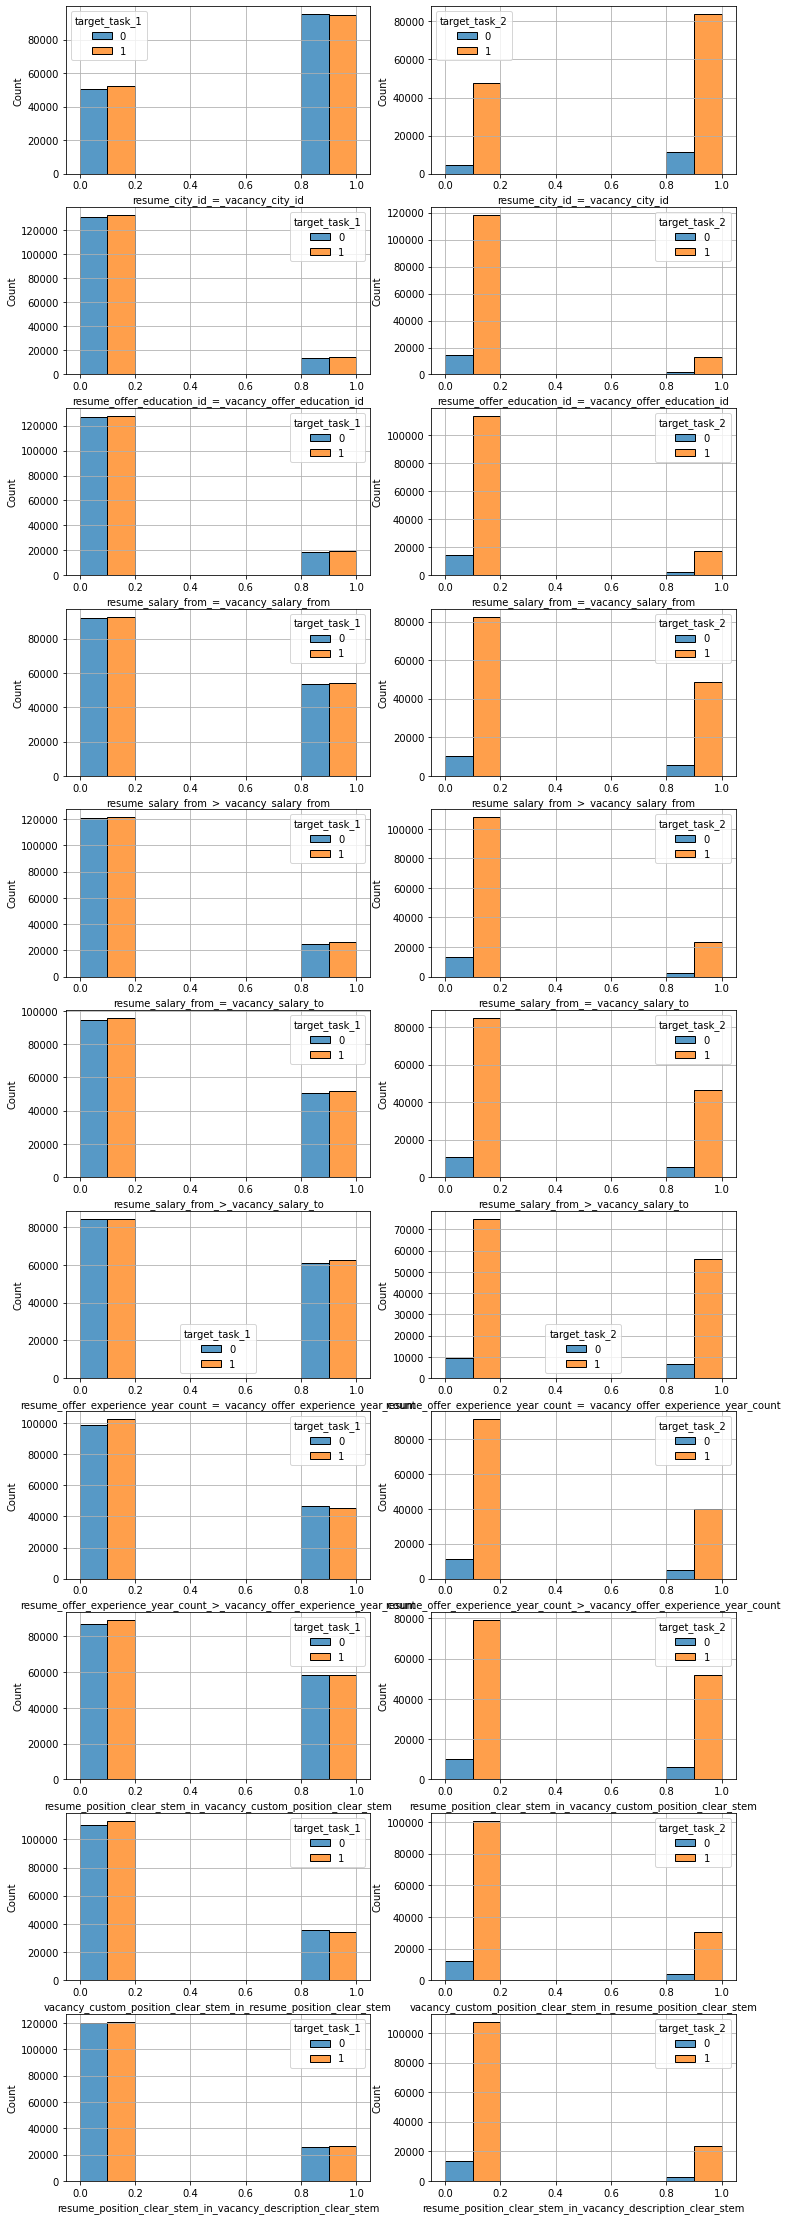

In [30]:
plotter_2cols(new_features, figsize=(12, 40), binwidth=0.2)

Большинство гистограмм созданных признаков соответствуют, распределениям определенным ранее: 50/50 для первой задачи и 90/10 для второй.
В тоже время для признаков сравнения опыта в резюме и вакансии наблюдается дисбаланс в первой задаче, что должно положительно сказаться на результатах моделирования.  

## Расстояния между текстовыми признаками

Построим гистограммы распределения расстояний между текстовыми признаками.

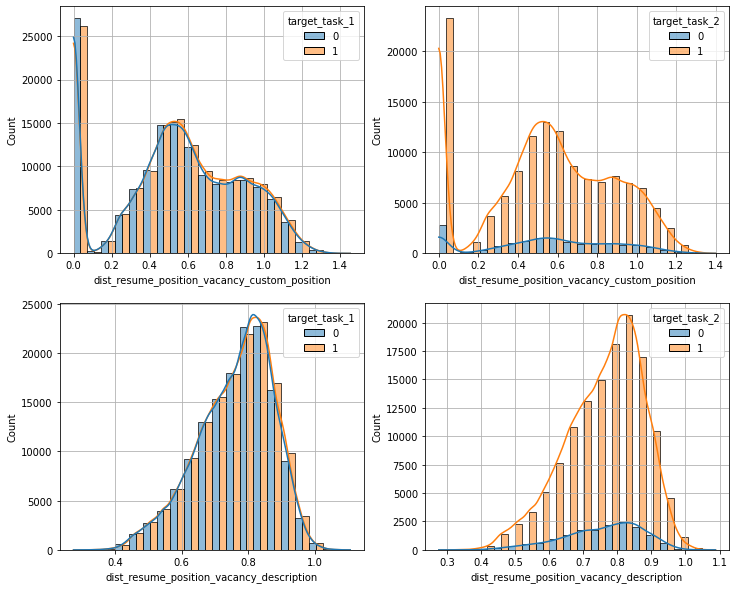

In [31]:
plotter_2cols(dist_features, kde=True, figsize=(12, 10), bins=20)

Полученные графики в целом соответствуют рассмотренным ранее распределениям. 

## Длина текстовых признаков

Построим гистограммы распределения длины текстовых признаков.

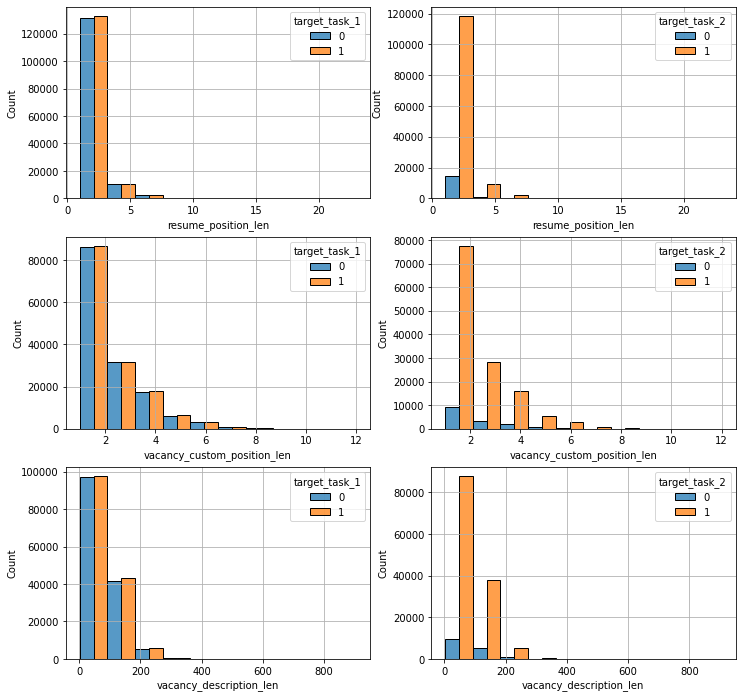

In [32]:
plotter_2cols(len_features, figsize=(12, 12), bins=10)

Полученные гистограммы свидетельствуют о "длинных хвостах", что зашумляет данные для моделирования и отрицательно сказывается на качестве работы моделей машинного обучения.
Исключим из рассмотрения объекты со значением рассмотренных признаков более 99,5-перцентиля (2 сигмы).

In [33]:
for i in len_features:
    df = df.drop(df[df[i] > df[i].quantile(0.995)].index, axis=0)

df_task_2 = df[df["target_task_1"] == 1]

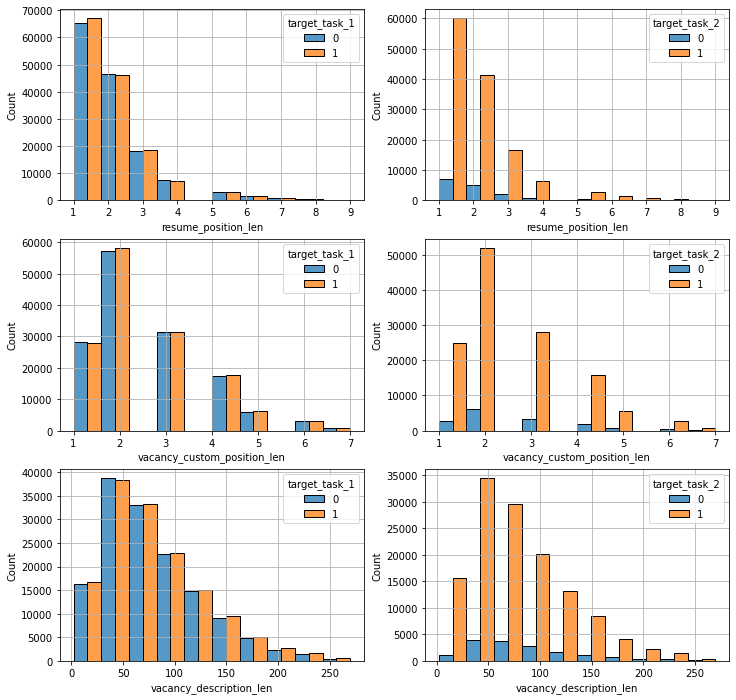

In [34]:
plotter_2cols(len_features, figsize=(12, 12), bins=10)

Хвосты исключены, а распределения соответствуют полученным ранее.

## Логарифмы

Построим гистограммы распределения признаков до логарифмирования и после.

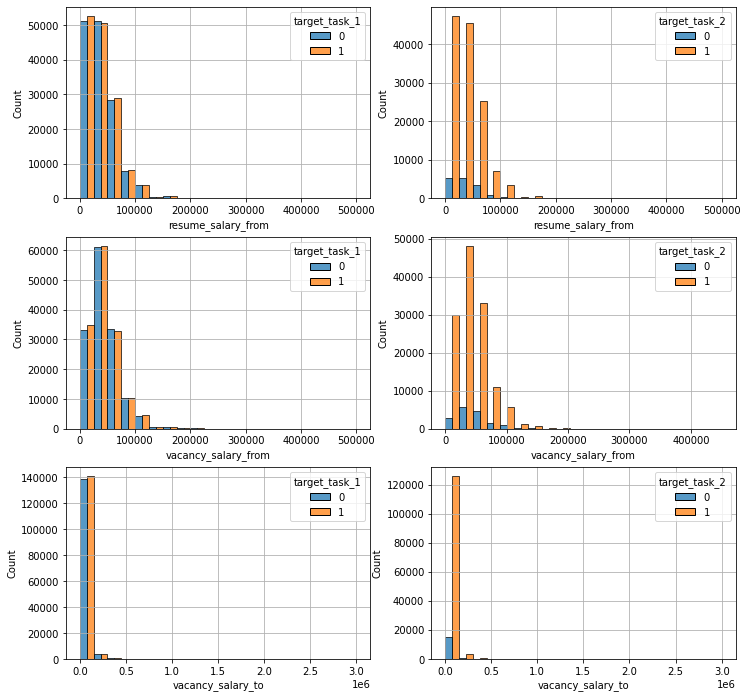

In [35]:
plotter_2cols(log_features, figsize=(12, 12), bins=20)

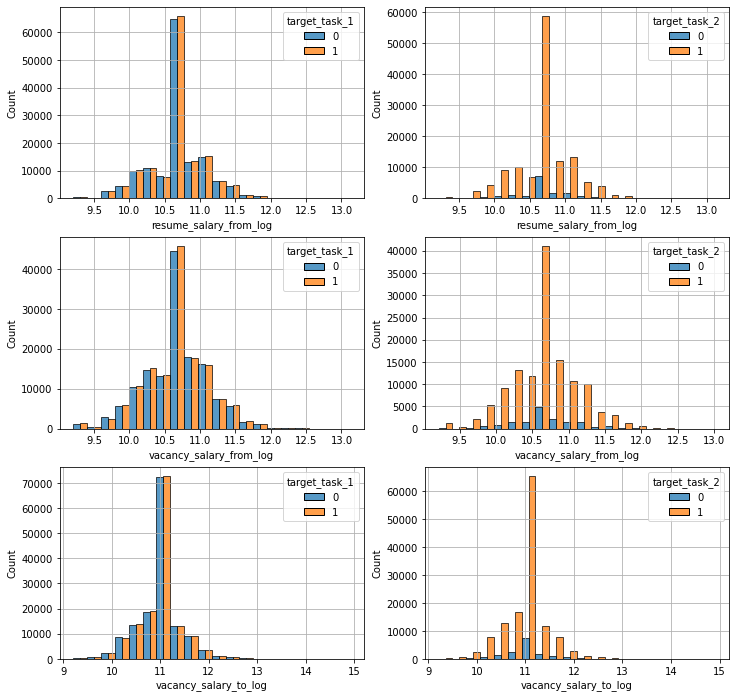

In [36]:
plotter_2cols(new_log_features, figsize=(12, 12), bins=20)

Распределения существенно изменились и приняли вид, близкий к нормальному, которое должно положительно сказаться на качестве моделирования.

## Свертка

Построим гистограммы распределения признаков свертки.

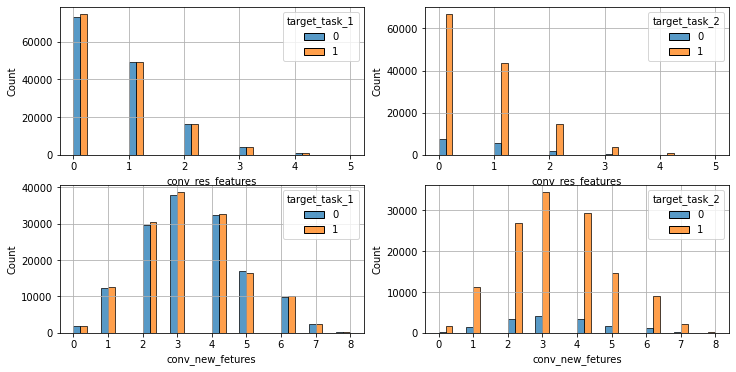

In [37]:
plotter_2cols(conv_features, figsize=(12, 6), bins=20)

В целом, распределения повторяют полученные ранее, но для первой задачи наблюдается незначительный дисбаланс классов целевого признака.
В этой связи, признаки могут оказать значимое влияение на результаты моделирования.

## Phik

Построим матрицу корреляции phik созданных признаков с целевыми.

In [38]:
phik_new = df[
    new_features + dist_features + len_features + new_log_features + conv_features + y_s
].phik_matrix()

interval columns not set, guessing: ['resume_city_id_=_vacancy_city_id', 'resume_offer_education_id_=_vacancy_offer_education_id', 'resume_salary_from_=_vacancy_salary_from', 'resume_salary_from_>_vacancy_salary_from', 'resume_salary_from_=_vacancy_salary_to', 'resume_salary_from_>_vacancy_salary_to', 'resume_offer_experience_year_count_=_vacancy_offer_experience_year_count', 'resume_offer_experience_year_count_>_vacancy_offer_experience_year_count', 'resume_position_clear_stem_in_vacancy_custom_position_clear_stem', 'vacancy_custom_position_clear_stem_in_resume_position_clear_stem', 'resume_position_clear_stem_in_vacancy_description_clear_stem', 'dist_resume_position_vacancy_custom_position', 'dist_resume_position_vacancy_description', 'resume_position_len', 'vacancy_custom_position_len', 'vacancy_description_len', 'resume_salary_from_log', 'vacancy_salary_from_log', 'vacancy_salary_to_log', 'conv_res_features', 'conv_new_fetures', 'target_task_1', 'target_task_2']


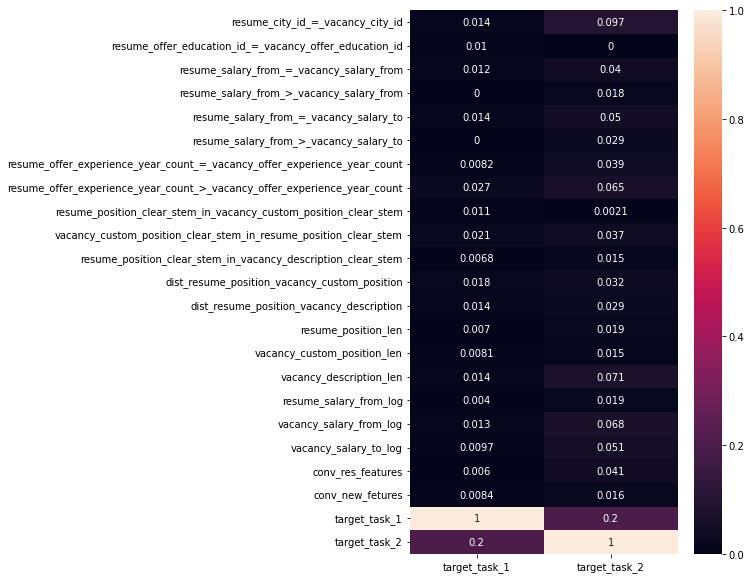

In [39]:
plt.figure(figsize=(6, 10))
sns.heatmap(phik_new[y_s], annot=True)
plt.show()

Полученная тепловая карта показывает, что с целевым признаком первой задачи созданные признаки коррелируют менее, чем на 3%. 
В тоже время их связь с целевым признаком второй задачи до 3 раз выше и достигает 9%. 
При этом "самый сильный" признак - сравнение опыта резюме и вакансии.



# Заключение по feature engineering

Проведена работа с перечнем фичей, в ходе которой в датасет добавлены следующие группы:
- равенства значений признаков с id городов, образования и т.п.;
- текстовых эмбеддингов при помощи библиотеки fasttext;
- длины текстовых признаков;
- логарифмирование признаков цены;
- свертка категориальных признаков в один.

Корреляции сфорированных признаков с целевыми не превосходит 3% для первой задачи и 9% для второй. 
В этой связи можно ожидать отсуствие их влияния на качество моделирования, что будет определено на следующем этапе.

Сохраним сформированный датасет в отдельный файл.

In [ ]:
df.to_csv("vacancy_resume_data_preprocesed.csv", index=False)